# Deep Learning for Diabetes Detection Using Kolmogorov-Arnold Networks
## By Erin Gregoire, Daniel Viola, & Dawson Damuth
### July 2025

In [1]:
from kan import *

import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import copy
import os

import torch
from torch.utils.data import TensorDataset, DataLoader
import torchinfo
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics import ROC

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using device: {device}')

using device: cuda


### Data Import and Preprocessing

In [4]:
import kagglehub
path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")
files = os.listdir(path)
data = pd.read_csv(os.path.join(path, files[2]))

In [5]:
numerical_features = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age']
binary_features = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
                   'HeartDiseaseorAttack', 'PhysActivity', 'Fruits',
                   'NoDocbcCost', 'DiffWalk', 'Sex']
categorical_features = ['Education', 'Income']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('bin', 'passthrough', binary_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

X = data.drop('Diabetes_binary', axis=1)
y = data['Diabetes_binary']

X_processed = preprocessor.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_processed, y, test_size=0.2, random_state=676, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=676, stratify=y_temp)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

print('X train:', X_train.shape, '| y train:', y_train.shape)
print('X validation:', X_val.shape, '| y validation:', y_val.shape)
print('X test:', X_test.shape, '| y test:', y_test.shape)

X train: (202944, 30) | y train: (202944,)
X validation: (25368, 30) | y validation: (25368,)
X test: (25368, 30) | y test: (25368,)


In [6]:
print('Number of classes:', len(y_train_tensor.unique()))

Number of classes: 2


In [7]:
dataset = {
    'train_input': X_train_tensor.to(device),
    'train_label': y_train_tensor.squeeze().long().to(device),
    'test_input': X_val_tensor.to(device),
    'test_label': y_val_tensor.squeeze().long().to(device)}

In [8]:
# handling class imbalance
labels = dataset['train_label']
num_class0 = (labels == 0).sum().item()
num_class1 = (labels == 1).sum().item()

total = num_class0 + num_class1
weight_0 = total / (2 * num_class0)
weight_1 = total / (2 * num_class1)

class_weights = torch.tensor([weight_0, weight_1], dtype=torch.float32).to(device)

### KAN Architecture

In [31]:
net = KAN(width=[30, 2, 2], grid=3, k=3, seed=676, device=device)
# 30 input features, 2 hidden layers, 2 outputs, 3 grids, cubic spline

checkpoint directory created: ./model
saving model version 0.0


In [33]:
torchinfo.summary(net)

Layer (type:depth-idx)                   Param #
MultKAN                                  16
├─ModuleList: 1-1                        --
│    └─KANLayer: 2-1                     840
│    │    └─SiLU: 3-1                    --
│    └─KANLayer: 2-2                     56
│    │    └─SiLU: 3-2                    --
├─SiLU: 1-2                              --
├─ModuleList: 1-3                        --
│    └─Symbolic_KANLayer: 2-3            300
│    └─Symbolic_KANLayer: 2-4            20
Total params: 1,232
Trainable params: 768
Non-trainable params: 464

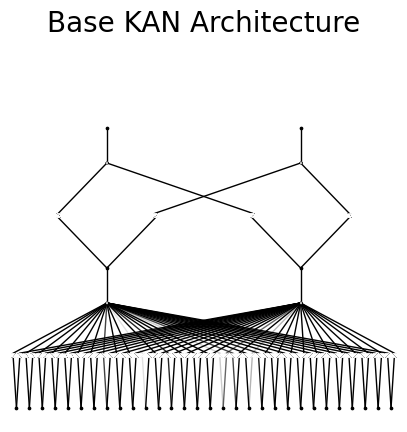

In [35]:
net(X_train_tensor.to(device));
net.plot(beta=100, title = 'Base KAN Architecture')

### Training the model

In [16]:
dtype = torch.get_default_dtype()
def train_acc():
    return torch.mean((torch.argmax(net(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))
def test_acc():
    return torch.mean((torch.argmax(net(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

In [69]:
net = KAN(width=[30, 1, 2], grid=3, k=3, seed=676, device=device)

epochs = 10
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []
for i in range(epochs):
    results = net.fit(dataset, opt='Adam', steps=1, lamb=0, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss());
    train_loss.append(results['train_loss'][-1].item())
    val_loss.append(results['test_loss'][-1].item())
    train_accuracy.append(results['train_acc'][-1])
    val_accuracy.append(results['test_acc'][-1])

print('Loss: training = {}, validation = {}'.format(train_loss[-1], val_loss[-1]))
print('Accuracy: training = {}%, validation = {}%'.format(train_accuracy[-1], val_accuracy[-1]))

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.27e-01 | test_loss: 3.68e+00 | reg: 1.11e+01 | : 100%|█| 1/1 [00:00<00:00,  1.54it/s


saving model version 0.1


| train_loss: 3.29e+00 | test_loss: 1.36e+00 | reg: 6.72e+01 | : 100%|█| 1/1 [00:00<00:00,  2.59it/s


saving model version 0.2


| train_loss: 1.24e+00 | test_loss: 6.20e+00 | reg: 6.85e+01 | : 100%|█| 1/1 [00:00<00:00,  2.63it/s


saving model version 0.3


| train_loss: 1.37e+01 | test_loss: 2.07e+00 | reg: 1.22e+03 | : 100%|█| 1/1 [00:00<00:00,  2.69it/s


saving model version 0.4


| train_loss: 1.45e+01 | test_loss: 4.65e+01 | reg: 1.35e+04 | : 100%|█| 1/1 [00:00<00:00,  2.67it/s


saving model version 0.5


| train_loss: 9.77e-01 | test_loss: 7.82e-01 | reg: 1.11e+06 | : 100%|█| 1/1 [00:00<00:00,  2.72it/s


saving model version 0.6


| train_loss: 7.66e+00 | test_loss: 2.36e+02 | reg: 1.09e+08 | : 100%|█| 1/1 [00:00<00:00,  2.56it/s


saving model version 0.7


| train_loss: 4.55e+04 | test_loss: 1.21e+04 | reg: 6.20e+09 | : 100%|█| 1/1 [00:00<00:00,  2.67it/s


saving model version 0.8


| train_loss: 5.01e+02 | test_loss: 1.66e+04 | reg: 1.27e+11 | : 100%|█| 1/1 [00:00<00:00,  2.34it/s


saving model version 0.9


| train_loss: 1.50e+05 | test_loss: 6.64e+05 | reg: 6.00e+11 | : 100%|█| 1/1 [00:00<00:00,  2.27it/s

saving model version 0.10
Loss: training = 150448.46875, validation = 663630.8125
Accuracy: training = 0.13933400809764862%, validation = 0.139309361577034%


### Hyperparameter Tuning

In [13]:
# trying different values of lambda
lambda_vals = [0, .01, .1, .25, .5, 1]

for i in range(len(lambda_vals)):
    net = KAN(width=[30, 1, 2], grid=3, k=3, seed=676, device=device)
    results = net.fit(dataset, opt='Adam', steps=10, lamb=lambda_vals[i], 
                      metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss(weight=class_weights));
    train_loss_ = results['train_loss'][-1].item()
    val_loss_ = results['test_loss'][-1].item()
    train_acc_ = results['train_acc'][-1]
    val_acc_ = results['test_acc'][-1]
    print(f'Lambda Value = {lambda_vals[i]}: Training Loss = {round(train_loss_, 4)}, Val Loss = {round(val_loss_, 4)}, Training Accuracy = {round(train_acc_*100, 4)}%, Val Accuracy = {round(val_acc_*100, 4)}%')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.30e-01 | test_loss: 8.30e-01 | reg: 1.41e+02 | : 100%|█| 10/10 [00:02<00:00,  4.69it


saving model version 0.1
Lambda Value = 0: Training Loss = 0.8305, Val Loss = 0.8303, Training Accuracy = 86.0666%, Val Accuracy = 86.0691%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.07e-01 | test_loss: 8.36e-01 | reg: 8.90e+01 | : 100%|█| 10/10 [00:01<00:00,  5.56it


saving model version 0.1
Lambda Value = 0.01: Training Loss = 0.9073, Val Loss = 0.8364, Training Accuracy = 76.8335%, Val Accuracy = 76.6359%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.29e-01 | test_loss: 8.33e-01 | reg: 9.42e+01 | : 100%|█| 10/10 [00:01<00:00,  5.57it


saving model version 0.1
Lambda Value = 0.1: Training Loss = 0.8292, Val Loss = 0.8325, Training Accuracy = 86.0666%, Val Accuracy = 86.0691%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.40e-01 | test_loss: 8.33e-01 | reg: 3.73e+01 | : 100%|█| 10/10 [00:01<00:00,  5.62it


saving model version 0.1
Lambda Value = 0.25: Training Loss = 0.8399, Val Loss = 0.8329, Training Accuracy = 13.9334%, Val Accuracy = 13.9309%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.46e-01 | test_loss: 8.34e-01 | reg: 3.98e+01 | : 100%|█| 10/10 [00:01<00:00,  5.61it


saving model version 0.1
Lambda Value = 0.5: Training Loss = 0.8464, Val Loss = 0.8339, Training Accuracy = 83.8951%, Val Accuracy = 83.9522%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.94e-01 | test_loss: 8.98e-01 | reg: 3.89e+01 | : 100%|█| 10/10 [00:01<00:00,  5.59it


saving model version 0.1
Lambda Value = 1: Training Loss = 0.8943, Val Loss = 0.8983, Training Accuracy = 13.9339%, Val Accuracy = 13.9309%


In [20]:
# trying different numbers of hidden layers
hidden_layers = [1, 3, 5, 10, 15]

for i in range(len(hidden_layers)):
    net = KAN(width=[30, hidden_layers[i], 2], grid=3, k=3, seed=676, device=device)
    results = net.fit(dataset, opt='Adam', steps=10, lamb=.5, 
                      metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss(weight=class_weights));
    train_loss_ = results['train_loss'][-1].item()
    val_loss_ = results['test_loss'][-1].item()
    train_acc_ = results['train_acc'][-1]
    val_acc_ = results['test_acc'][-1]
    print(f'# of Hidden Layers = {hidden_layers[i]}: Training Loss = {round(train_loss_, 4)}, Val Loss = {round(val_loss_, 4)}, Training Accuracy = {round(train_acc_*100, 4)}%, Val Accuracy = {round(val_acc_*100, 4)}%')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.46e-01 | test_loss: 8.34e-01 | reg: 3.98e+01 | : 100%|█| 10/10 [00:02<00:00,  4.68it


saving model version 0.1
# of Hidden Layers = 1: Training Loss = 0.8464, Val Loss = 0.8339, Training Accuracy = 83.8951%, Val Accuracy = 83.9522%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.19e-01 | test_loss: 2.37e+00 | reg: 1.24e+02 | : 100%|█| 10/10 [00:02<00:00,  3.36it


saving model version 0.1
# of Hidden Layers = 3: Training Loss = 0.9187, Val Loss = 2.3655, Training Accuracy = 13.9664%, Val Accuracy = 13.9664%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.12e+00 | test_loss: 1.25e+00 | reg: 1.36e+02 | : 100%|█| 10/10 [00:03<00:00,  2.86it


saving model version 0.1
# of Hidden Layers = 5: Training Loss = 1.1221, Val Loss = 1.249, Training Accuracy = 85.8079%, Val Accuracy = 85.7458%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.45e+00 | test_loss: 3.02e+00 | reg: 3.43e+02 | : 100%|█| 10/10 [00:04<00:00,  2.05it


saving model version 0.1
# of Hidden Layers = 10: Training Loss = 2.4462, Val Loss = 3.0168, Training Accuracy = 14.0108%, Val Accuracy = 14.0453%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.04e+00 | test_loss: 1.29e+00 | reg: 4.12e+02 | : 100%|█| 10/10 [00:10<00:00,  1.09s/


saving model version 0.1
# of Hidden Layers = 15: Training Loss = 2.0411, Val Loss = 1.2855, Training Accuracy = 69.9252%, Val Accuracy = 69.43%


In [22]:
# trying different optimizers
optimizers = ['LBFGS', 'Adam', 'AdamW', 'SGD', 'Adagrad', 'RMSProp']

for i in range(len(optimizers)):
    net = KAN(width=[30, 1, 2], grid=3, k=3, seed=676, device=device)
    results = net.fit(dataset, opt=optimizers[i], steps=10, lamb=.5, 
                      metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss(weight=class_weights));
    train_loss_ = results['train_loss'][-1].item()
    val_loss_ = results['test_loss'][-1].item()
    train_acc_ = results['train_acc'][-1]
    val_acc_ = results['test_acc'][-1]
    print(f'Optimizer = {optimizers[i]}: Training Loss = {round(train_loss_, 4)}, Val Loss = {round(val_loss_, 4)}, Training Accuracy = {round(train_acc_*100, 4)}%, Val Accuracy = {round(val_acc_*100, 4)}%')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.31e-01 | test_loss: 8.32e-01 | reg: 4.64e+00 | : 100%|█| 10/10 [00:15<00:00,  1.55s/


saving model version 0.1
Optimizer = LBFGS: Training Loss = 0.8315, Val Loss = 0.8316, Training Accuracy = 13.9334%, Val Accuracy = 13.9309%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.46e-01 | test_loss: 8.34e-01 | reg: 3.98e+01 | : 100%|█| 10/10 [00:01<00:00,  5.46it


saving model version 0.1
Optimizer = Adam: Training Loss = 0.8465, Val Loss = 0.8339, Training Accuracy = 84.0956%, Val Accuracy = 84.0744%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.46e-01 | test_loss: 8.33e-01 | reg: 3.98e+01 | : 100%|█| 10/10 [00:01<00:00,  8.53it


saving model version 0.1
Optimizer = AdamW: Training Loss = 0.8465, Val Loss = 0.8326, Training Accuracy = 44.4556%, Val Accuracy = 44.631%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.46e-01 | test_loss: 8.33e-01 | reg: 3.98e+01 | : 100%|█| 10/10 [00:01<00:00,  8.38it


saving model version 0.1
Optimizer = SGD: Training Loss = 0.8465, Val Loss = 0.8326, Training Accuracy = 44.4556%, Val Accuracy = 44.631%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.46e-01 | test_loss: 8.33e-01 | reg: 3.98e+01 | : 100%|█| 10/10 [00:01<00:00,  8.55it


saving model version 0.1
Optimizer = Adagrad: Training Loss = 0.8465, Val Loss = 0.8326, Training Accuracy = 44.4556%, Val Accuracy = 44.631%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.46e-01 | test_loss: 8.33e-01 | reg: 3.98e+01 | : 100%|█| 10/10 [00:01<00:00,  8.60it


saving model version 0.1
Optimizer = RMSProp: Training Loss = 0.8465, Val Loss = 0.8326, Training Accuracy = 44.4556%, Val Accuracy = 44.631%


In [24]:
# trying different values of lambda entropy
lambda_vals = [0, 1, 2, 5, 8, 10]

for i in range(len(lambda_vals)):
    net = KAN(width=[30, 1, 2], grid=3, k=3, seed=676, device=device)
    results = net.fit(dataset, opt='Adam', steps=10, lamb=.5, lamb_entropy=lambda_vals[i], 
                      metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss(weight=class_weights));
    train_loss_ = results['train_loss'][-1].item()
    val_loss_ = results['test_loss'][-1].item()
    train_acc_ = results['train_acc'][-1]
    val_acc_ = results['test_acc'][-1]
    print(f'Lambda Entropy = {lambda_vals[i]}: Training Loss = {round(train_loss_, 4)}, Val Loss = {round(val_loss_, 4)}, Training Accuracy = {round(train_acc_*100, 4)}%, Val Accuracy = {round(val_acc_*100, 4)}%')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.84e-01 | test_loss: 8.79e-01 | reg: 3.69e+01 | : 100%|█| 10/10 [00:02<00:00,  4.78it


saving model version 0.1
Lambda Entropy = 0: Training Loss = 0.8845, Val Loss = 0.8788, Training Accuracy = 29.8871%, Val Accuracy = 29.482%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.14e+00 | test_loss: 9.40e-01 | reg: 3.22e+01 | : 100%|█| 10/10 [00:01<00:00,  5.51it


saving model version 0.1
Lambda Entropy = 1: Training Loss = 1.1415, Val Loss = 0.9404, Training Accuracy = 30.1876%, Val Accuracy = 30.1403%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.46e-01 | test_loss: 8.34e-01 | reg: 3.98e+01 | : 100%|█| 10/10 [00:01<00:00,  5.61it


saving model version 0.1
Lambda Entropy = 2: Training Loss = 0.8464, Val Loss = 0.8339, Training Accuracy = 83.8951%, Val Accuracy = 83.9522%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.29e-01 | test_loss: 8.36e-01 | reg: 5.73e+01 | : 100%|█| 10/10 [00:01<00:00,  5.57it


saving model version 0.1
Lambda Entropy = 5: Training Loss = 0.8288, Val Loss = 0.8363, Training Accuracy = 83.7054%, Val Accuracy = 83.7039%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.53e-01 | test_loss: 8.54e-01 | reg: 7.44e+01 | : 100%|█| 10/10 [00:01<00:00,  5.61it


saving model version 0.1
Lambda Entropy = 8: Training Loss = 0.8528, Val Loss = 0.8538, Training Accuracy = 15.2949%, Val Accuracy = 15.3185%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.51e-01 | test_loss: 8.52e-01 | reg: 9.63e+01 | : 100%|█| 10/10 [00:01<00:00,  5.53it


saving model version 0.1
Lambda Entropy = 10: Training Loss = 0.8513, Val Loss = 0.8521, Training Accuracy = 13.9487%, Val Accuracy = 13.9506%


In [26]:
# trying different types of regularization
regs = ['edge_forward_spline_n', 'edge_forward_sum', 'edge_forward_spline_u', 'edge_backward', 'node_backward']

for i in range(len(regs)):
    net = KAN(width=[30, 1, 2], grid=3, k=3, seed=676, device=device)
    results = net.fit(dataset, opt='Adam', steps=10, lamb=.5, lamb_entropy=5, reg_metric=regs[i],
                      metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss(weight=class_weights));
    train_loss_ = results['train_loss'][-1].item()
    val_loss_ = results['test_loss'][-1].item()
    train_acc_ = results['train_acc'][-1]
    val_acc_ = results['test_acc'][-1]
    print(f'Regularization Technique = {regs[i]}: Training Loss = {round(train_loss_, 4)}, Val Loss = {round(val_loss_, 4)}, Training Accuracy = {round(train_acc_*100, 4)}%, Val Accuracy = {round(val_acc_*100, 4)}%')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.29e-01 | test_loss: 8.36e-01 | reg: 5.73e+01 | : 100%|█| 10/10 [00:02<00:00,  4.26it


saving model version 0.1
Regularization Technique = edge_forward_spline_n: Training Loss = 0.8288, Val Loss = 0.8363, Training Accuracy = 83.6994%, Val Accuracy = 83.7039%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.30e-01 | test_loss: 8.30e-01 | reg: 1.55e+02 | : 100%|█| 10/10 [00:01<00:00,  5.70it


saving model version 0.1
Regularization Technique = edge_forward_sum: Training Loss = 0.8305, Val Loss = 0.8303, Training Accuracy = 86.0666%, Val Accuracy = 86.0691%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 6.02e+01 | : 100%|█| 10/10 [00:01<00:00,  5.60it


saving model version 0.1
Regularization Technique = edge_forward_spline_u: Training Loss = 0.8327, Val Loss = 0.8325, Training Accuracy = 86.0666%, Val Accuracy = 86.0691%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.20e+00 | test_loss: 1.10e+00 | reg: 3.26e+01 | : 100%|█| 10/10 [00:01<00:00,  5.51it


saving model version 0.1
Regularization Technique = edge_backward: Training Loss = 1.2023, Val Loss = 1.0959, Training Accuracy = 13.9334%, Val Accuracy = 13.9309%
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.30e-01 | test_loss: 8.43e-01 | reg: 4.72e+01 | : 100%|█| 10/10 [00:01<00:00,  5.35it


saving model version 0.1
Regularization Technique = node_backward: Training Loss = 0.8305, Val Loss = 0.8435, Training Accuracy = 85.7586%, Val Accuracy = 85.734%


Hyperparameters:
- Number of Hidden Layers = 1
- Lambda = .5
- Optimizer = Adam
- Lambda Entropy = 5
- Regularization = node_backward

### Saving the best model

In [77]:
net.auto_save # check that auto save is on

True

In [123]:
net = KAN(width=[30, 1, 2], grid=3, k=3, seed=676, device=device)

best_vloss = 1000000
best_model = [] # model saves automatically, just need # of best model

start_time = time.time()

results = net.fit(dataset, opt='Adam', steps=10, lamb=.5, lamb_entropy=5, reg_metric='node_backward',
                metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss(weight=class_weights));

train_accuracy = []
val_accuracy = []
for i in range(len(results['train_acc'])):
    acc = results['train_acc'][i] * 100
    train_accuracy.append(acc)
    vacc = results['test_acc'][i] * 100
    val_accuracy.append(vacc)
    
train_loss = results['train_loss']
val_loss = results['test_loss']

for j in val_loss:
    if j < best_vloss:
        best_vloss = j
        best_model.append(i)
this_one = best_model[-1]

print(f'Best Model = Model Version {this_one}')
print('Loss: training = {}, validation = {}'.format(train_loss[this_one], val_loss[this_one]))
print('Accuracy: training = {}%, validation = {}%'.format(train_accuracy[this_one], val_accuracy[this_one]))

end_time = time.time()
estimated_training_time = end_time - start_time
print(f'Estimated training time: {round(estimated_training_time/60, 2)} minutes')

checkpoint directory created: ./model
saving model version 0.0



description:   0%|                                                           | 0/10 [00:00<?, ?it/s]
| train_loss: 8.41e-01 | test_loss: 8.80e-01 | reg: 4.53e+01 | :   0%|       | 0/10 [00:00<?, ?it/s]
| train_loss: 8.41e-01 | test_loss: 8.80e-01 | reg: 4.53e+01 | :  10%| | 1/10 [00:00<00:07,  1.13it/
| train_loss: 8.84e-01 | test_loss: 8.33e-01 | reg: 4.78e+01 | :  10%| | 1/10 [00:01<00:07,  1.13it/
| train_loss: 8.84e-01 | test_loss: 8.33e-01 | reg: 4.78e+01 | :  20%|▏| 2/10 [00:01<00:03,  2.18it/
| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 1.55e+00 | :  20%|▏| 2/10 [00:01<00:03,  2.18it/
| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 1.55e+00 | :  30%|▎| 3/10 [00:01<00:02,  3.14it/
| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 5.34e-12 | :  30%|▎| 3/10 [00:01<00:02,  3.14it/
| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 5.34e-12 | :  40%|▍| 4/10 [00:01<00:01,  3.95it/
| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 0.00e+00 | :  40%|▍| 4/10 [00:01<00:01

saving model version 0.1
Best Model = Model Version 9
Loss: training = 0.8304876685142517, validation = 0.8434759974479675
Accuracy: training = 85.75863242149353%, validation = 85.73399782180786%
Estimated training time: 0.04 minutes


### Evaluation:

In [18]:
test_dataset = {
    'train_input': X_test_tensor.to(device),
    'train_label': y_test_tensor.squeeze().long().to(device),
    'test_input': X_test_tensor.to(device),
    'test_label': y_test_tensor.squeeze().long().to(device)}

In [32]:
net = KAN.loadckpt('./project_kan_library_dawsonda_dviola_ergregoi')
net.get_act(test_dataset)
results = net.fit(test_dataset, opt='Adam', steps=1, lamb=.5, lamb_entropy=5, reg_metric='node_backward',
                metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss());

test_accuracy = float(results['test_acc'][0]*100)
test_loss = float(results['test_loss'][0])

print('Loss: test = {}'.format(test_loss))
print('Accuracy: test = {}%'.format(test_accuracy))

| train_loss: 1.33e+01 | test_loss: 7.92e-01 | reg: 1.69e+01 | : 100%|█| 1/1 [00:00<00:00,  2.31it/s

saving model version 1.2
Loss: test = 0.7920668125152588
Accuracy: test = 73.52964282035828%


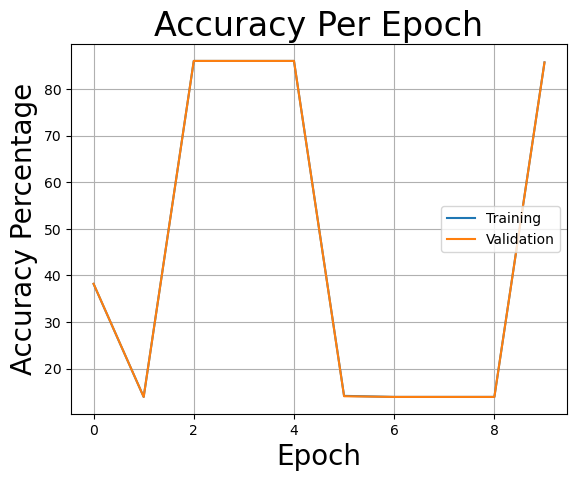

In [125]:
plt.figure()
plt.plot(train_accuracy, label = 'Training')
plt.plot(val_accuracy, label = 'Validation')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy Percentage', fontsize=20)
plt.title('Accuracy Per Epoch', fontsize=24)
plt.legend() 
plt.grid()
plt.show()

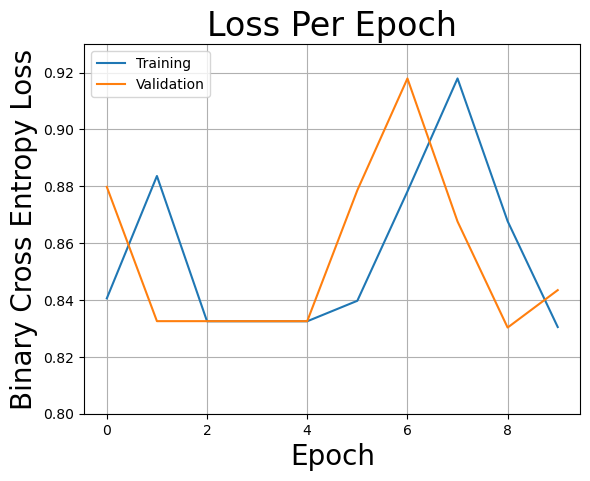

In [127]:
plt.figure()
plt.plot(train_loss, label = 'Training')
plt.plot(val_loss, label = 'Validation')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Binary Cross Entropy Loss', fontsize=20)
plt.title('Loss Per Epoch', fontsize=24)
plt.ylim(ymin=.8, ymax=.93)
plt.legend() 
plt.grid()
plt.show()

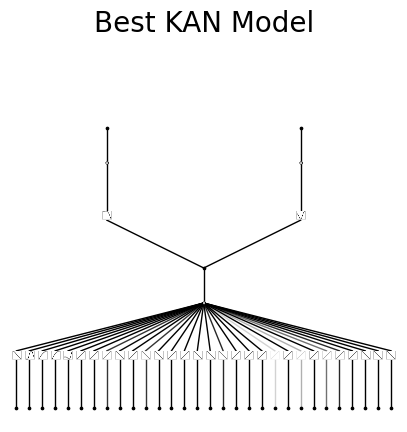

In [83]:
net.plot(beta=100, title='Best KAN Model')

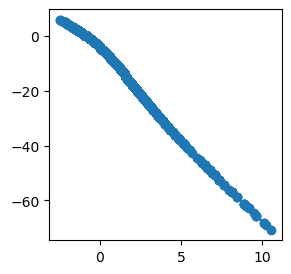

In [131]:
# activation functions
x, y = net.get_fun(0, 0, 0)

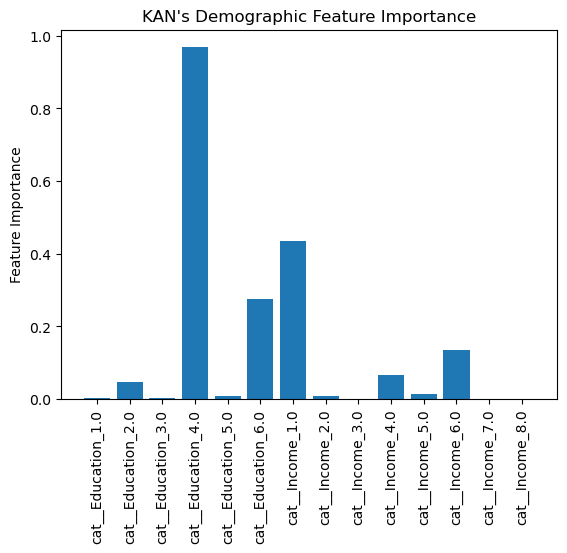

In [185]:
scores = net.feature_score
demo_scores = scores[16:31].cpu().detach().numpy()
features = preprocessor.get_feature_names_out()
demo_features = features[16:31]
y_pos = range(len(demo_features))

plt.figure()
plt.bar(y_pos, demo_scores)
plt.xticks(y_pos, demo_features, rotation=90);
plt.ylabel('Feature Importance')
plt.title("KAN's Demographic Feature Importance")
plt.show()

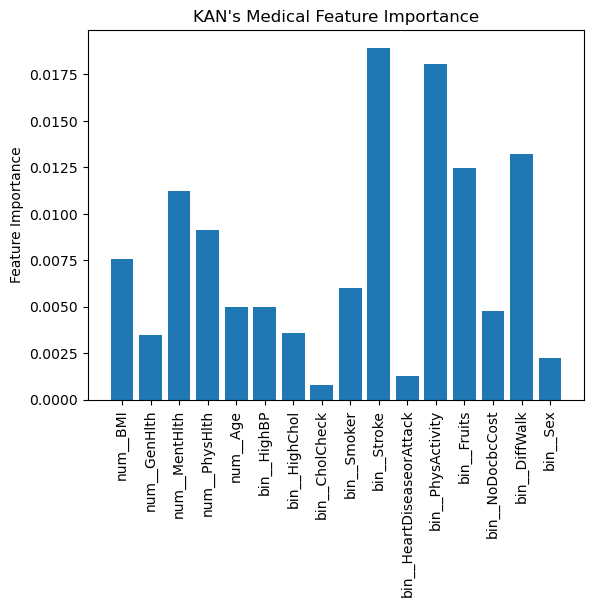

In [177]:
scores = net.feature_score
medical_scores = scores[0:16].cpu().detach().numpy()
features = preprocessor.get_feature_names_out()
medical_features = features[0:16]
y_pos = range(len(medical_features))

plt.figure()
plt.bar(y_pos, medical_scores)
plt.xticks(y_pos, medical_features, rotation=90);
plt.ylabel('Feature Importance')
plt.title("KAN's Medical Feature Importance")
plt.show()